# Medical Text Clustering

The MTSamples Dataset has medical transcriptions from several conditions and consultations. It also provides a medical speciality and keywords extracted manually from the transcription. The information however, is not very specific. For example, all of the `surgery` consultations are under the same `medical_speciality` field. Nonetheless, "surgery" is a very broad term, and it can go from minor molar procedures to life-or-death cardiovascular operations. 

The task is to run a clustering algorithm that is able to provide sub-groups within the surgery speciality. The end-goal is to have sub-topics clearly identified under the surgery category. 

In [2]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
# load from our own module
# Follow installation in the Readme beforehand!
from src.medical_nlp import utils

## Quick Data Exploration

## NLP 

In [3]:
# Load the model!
# For vectors, at least a size MD model is needed!
nlp = spacy.load("en_core_sci_md")

txt_col : str = "transcription"
data_path : str = "../data/mtsamples.csv"

# You can play with the params and see different results!
MODEL_PARAMS: dict = {
    "eps": 0.25,
    "min_samples": 12
}

/Users/kdlx593/miniconda3/envs/medical_nlp/lib/python3.11/site-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [4]:
df = pd.read_csv(data_path)
# drop nas from the text column
df = df[df[txt_col].notna()]
# Get only Surgery topics 
df = df[df["medical_specialty"] == " Surgery"].reset_index(drop=True)
# process the keywords as it will be easier to handle as a list of lists
df["processed_kw"] = df.keywords.apply(lambda row: utils.process_keywords(row))

In [5]:
# Get the vector representation of the transcription
# Takes around 5 minutes!
df["vectors"] = df[txt_col].apply(
    lambda sent : utils.get_vectors(sent, nlp)
)

## Build the Clustering Model 

We are going to use the DBSCAN unsupervised algorithm to build our clusters. This algorithm is particulary useful in finding non-linear relationships, based on densities. It does not require the user to "pre-define" a number of clusters (contrary to K-Means for example) and it works well with high dimmensions (such as word embeddings). 

More info: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

Advantages:

- You don't need to define the number of K.
- Robust to Oultiers, since its definition "labels" them as such if they do not have a considerable number of neighbors (low density)
- Excellent algorithm on arbitrary distributions

In [6]:
# Create DBScan model
# setting in the format DBScan requires
embeddings = utils.format_embeddings_for_clustering(df.vectors.values)  
# Performing DBSCAN clustering
dbscan = DBSCAN(
    **MODEL_PARAMS
)
# Get the clusters. Remember, -1 == outlier (Noise)!
labels = dbscan.fit_predict(embeddings)
# Add the labels back to the DF
df["cluster"] = labels

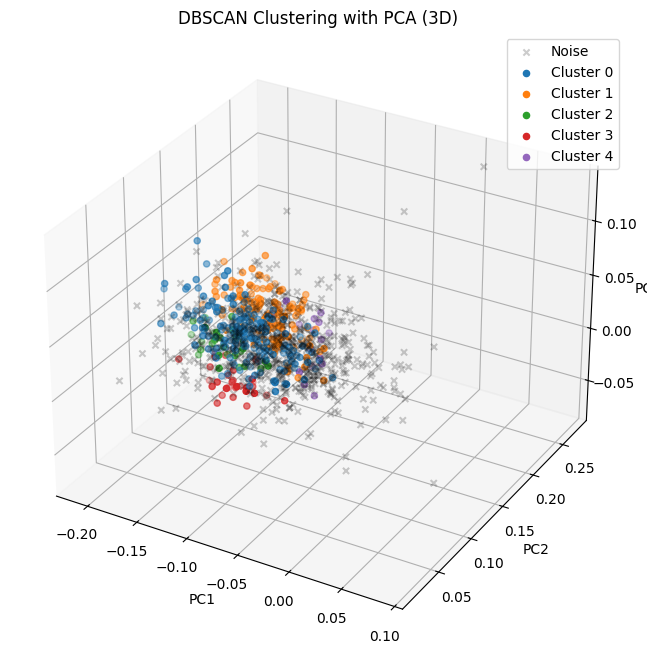

In [7]:
# Visualizing the clustering result
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Our embeddings have 200 dimmensions, and of course, we can't plot in 200D. 
# The best we can do is 3D, so we choose a random set of dimmensions.
d1 = 10
d2 = 20
d3 = 30
# Plot points belonging to cluster -1 with reduced alpha and a different marker
ax.scatter(
    embeddings[dbscan.labels_ == -1, d1], 
    embeddings[dbscan.labels_ == -1, d2], 
    embeddings[dbscan.labels_ == -1, d3], 
    c='black', marker='x', alpha=0.2, label='Noise'
)

# Plot points belonging to clusters other than -1
for label in set(dbscan.labels_) - {-1}:
    ax.scatter(
        embeddings[dbscan.labels_ == label, d1], 
        embeddings[dbscan.labels_ == label, d2], 
        embeddings[dbscan.labels_ == label, d3], 
        label=f'Cluster {label}'
)

ax.set_title('DBSCAN Clustering with PCA (3D)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

## Evaluate Clusters

In [12]:
from collections import Counter
# build a dictionary that will store most frequent terms
# per label
TOP_N : int = 10  # Top 10 terms
freq_dict: dict = {}
for label_ in df.cluster.unique():
    if label_ != -1:  # skip noise
        cluster_sample = df.query("cluster == @label_")
        # count word freq
        counts = Counter(
            x for sublist in cluster_sample.processed_kw.values
            for x in sublist 
            if x not in ["surgery", ""]  # skip surgery (present in all) and empty kw.
        ).most_common(TOP_N)
        # assign counter to dictionary.
        freq_dict[label_] = counts


In [13]:
# Let's give it a look
for key in freq_dict:
    print(f"Cluster {key}")
    print(freq_dict[key])
    print()

Cluster 0
[('tourniquet', 29), ('discectomy', 22), ('anterior', 21), ('foot', 20), ('cervical', 20), ('metatarsal', 18), ('knee', 18), ('anterior cervical discectomy', 18), ('femoral', 16), ('fracture', 16)]

Cluster 2
[('phacoemulsification', 20), ('eye', 19), ('cataract', 19), ('intraocular', 18), ('lens', 17), ('anterior chamber', 15), ('intraocular lens', 14), ('chamber', 13), ('capsular bag', 11), ('lid speculum', 10)]

Cluster 1
[('laparoscopic', 33), ('uterus', 16), ('uterine', 15), ('gallbladder', 14), ('cholecystectomy', 14), ('abdomen', 14), ('abdominal', 13), ('bladder', 13), ('laparoscopy', 12), ('metzenbaum scissors', 11)]

Cluster 3
[('coronary', 16), ('artery', 15), ('catheterization', 15), ('angiography', 14), ('coronary artery', 14), ('coronary angiography', 13), ('heart catheterization', 10), ('stenosis', 7), ('circumflex', 7), ('ventriculogram', 6)]

Cluster 4
[('colonoscopy', 10), ('esophagogastroduodenoscopy', 7), ('esophagus', 7), ('stomach', 6), ('biopsies', 6), 

We now have our clusters. What can you see?

- **Cluster 0** has to do with bone injuries, like broken feet, knee surgeries, cervical issues. 
- **Cluster 1** is clearly related to eye issues. Cataract and intraocular surgeries.
- **Cluster 2** is related to genitals and reproductory organs mainly.
- **Cluster 3** treats heart and cardivascular operations. 
- **Cluster 4** Mainly covers surgeries around the stomach and digestive system. 

The algorithm has "learnt" relevant patterns and has created actionable clusters! 

End of file